In [38]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from general_graph_utils import *

# plot formatting
plt.rc("text", usetex=False)
plt.rc("font", family = "serif")
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

Suppose our system is an enzyme that can convert through three states in a single cycle:

$$E_1 \rightleftharpoons E_2 \rightleftharpoons E_3 \rightleftharpoons E_1$$

Let us label the edge $\ell(i \to j)$ as $k^+_i$, and its reverse $\ell(j \to i)$ as $k^-_i$. The cycle force $\mathcal{A}$ is given as

$$\mathcal{A} = \ln  \prod_{i = 1}^N \dfrac{k^+_i}{k^-_i} \, . $$

Say the enzyme can only be phosphorylated in $E_1$. That is, the system consumes one $ATP$ molecule as $E_2$ converts to $E_3$, and produces one $ATP + P_i$ as $E_3$ converts to $E_1$ (not convinced this is correct but we'll try it out and see). Our cycle force can be expressed in terms of the chemical potential.

$$\mathcal{A} = \mu_{ATP} - \mu_{ADP} - \mu_{P_i}$$

In [87]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3, weight = 1.0)
G.add_edge(3,1, weight = 1.0)
G.add_edge(2,3, weight = 1.0)
G.add_edge(3,2, weight = 1.0)
G.add_edge(1,2, weight = 1.0)
G.add_edge(2,1, weight = 1.0)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

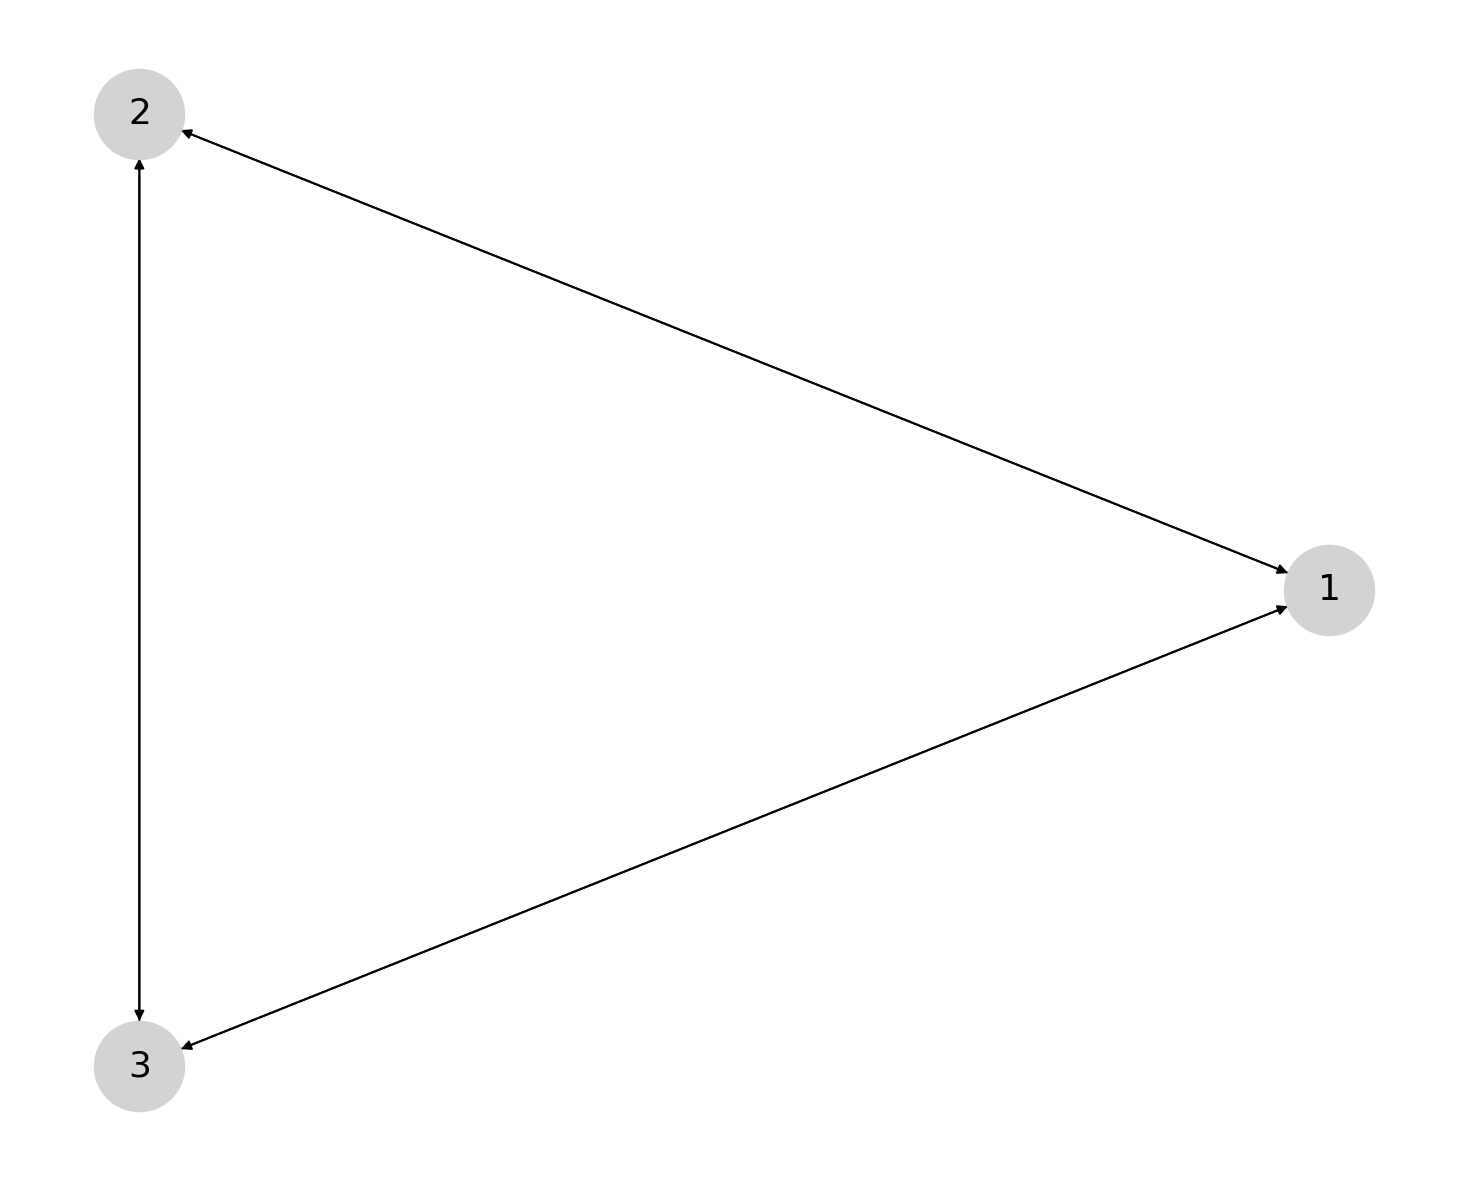

In [88]:
node_labels = {}
node_labels[1] = "1"
node_labels[2] = "2"
node_labels[3] = "3"
nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

In [89]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [90]:
label_dict, label_list = get_labels(G)

In [91]:
label_dict

{(1, 3): 1.0, (1, 2): 1.0, (2, 3): 3.0, (2, 1): 1.0, (3, 1): 0.5, (3, 2): 1.0}

In [92]:
label_list

array([1. , 1. , 3. , 1. , 0.5, 1. ])

In [93]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [94]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[0.40546511]


In [95]:
L = Laplacian_all(edge_list,label_list,node_list)
pi = steady_state_spectrum(L)

In [96]:
pi

array([0.4 , 0.44, 0.16])

Calculate correlation function

How do we enforce the initial conditions we want?

* Concentrate all probability at one node
* Enforce a flux in one direction

In [97]:
eigvals, eigvecs = scipy.linalg.eig(L)

In [98]:
eigvals

array([ 0. +0.j, -2.5+0.j, -5. +0.j])

In [99]:
all_labels = np.zeros((100,6))
all_eigvals_real = np.zeros((100,3))
all_eigvals_complex = np.zeros((100,3))

all_eigvals_real[1]

array([0., 0., 0.])

In [100]:
for i in range(100):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    all_eigvals_real[i] = eigvals.real
    all_eigvals_complex[i] = eigvals.imag

In [164]:
t = np.around(np.arange(0.0,20.0,step=.01), decimals = 2)

In [165]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

In [166]:
L

array([[-1.5,  1. ,  1. ],
       [ 1. , -2. ,  3. ],
       [ 0.5,  1. , -4. ]], dtype=float128)

In [184]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

P_0 = np.array([1,0,0])

new_list = np.zeros((len(t),3))

for i in range(len(t)):
    new_list[i] = ((list_result[i]*P_0)[0])[0]

In [185]:
new_list[0]

array([1., 1., 1.])

In [186]:
((L*P_0)[:,0])

array([-1.5,  1. ,  0.5], dtype=float128)

Text(0, 0.5, 'C_1,1(t)')

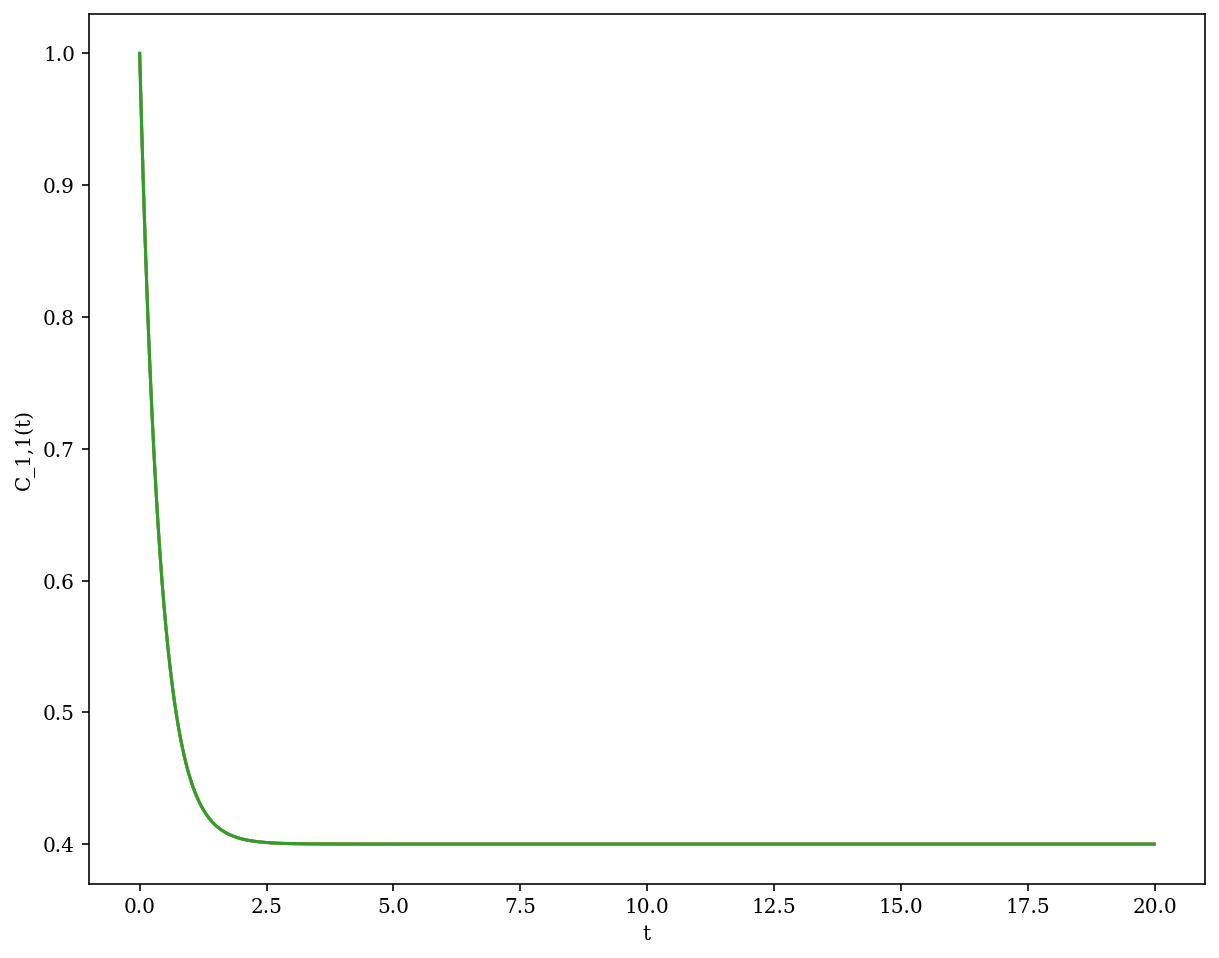

In [187]:
plt.plot(t, new_list)
plt.xlabel('t')
plt.ylabel('C_1,1(t)')
#plt.legend()